In [19]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh
from scipy.optimize import curve_fit
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size']=20
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
from scipy.special import eval_genlaguerre, gamma, hyp1f1

In [2]:
@numba.jit(complex128[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GOE(N, sigma):
    H=np.zeros((N, N), dtype=complex128)
    for j in range(N):
        for k in range(j, N):
            a=np.random.normal(0,sigma)
            H[j,k]=a
            H[k,j]=a
    return H
@numba.njit(complex128[:,:](int64, float64))
def RMT_GUE(N, sigma):
    H=np.zeros((N, N), dtype=complex128)
    for j in range(N):
        H[j,j]=np.random.normal(0,sigma)
        for k in range(j+1, N):
            a=np.random.normal(0,sigma)/np.sqrt(2)
            b=np.random.normal(0,sigma)/np.sqrt(2)
            H[j,k]=complex(a,b)
            H[k,j]=complex(a,-b)
    #auxH=np.random.randn(N, N)+i*np.random.randn(N, N)
    #H=(auxH+auxH.conj().T)/2
    return H
@numba.njit()
def Averageaxis0(arr, d0, d1):
    arrout=np.zeros(d1)
    for k in range(d1):
        arrout[k]=np.sum(arr[:,k])/d0
    return arrout
@numba.njit()
def NumericsGUE(Nav, dim, b):
    nbeta=len(b)
    avE=np.zeros((Nav, nbeta))
    stdE=np.zeros((Nav, nbeta))
    minE=np.zeros((Nav, nbeta))
    avZ=np.zeros((Nav, nbeta))
    NA_stdE=np.zeros((Nav, nbeta))
    NA_avE=np.zeros((Nav, nbeta))
    avE_minE=np.zeros((Nav, nbeta))
    for k in range(nbeta):
        for j in range(Nav):
            H=RMT_GUE(dim,1/np.sqrt(2))
            E,_=eigh(H)
            Z=np.sum(np.exp(-b[k]*E))
            avZ[j,k]=Z
            avE[j,k]=np.sum(E*np.exp(-b[k]*E))
            stdE[j,k]=np.sum((E)**2*np.exp(-b[k]*E))
            minE[j,k]=np.min(E)
            NA_stdE[j,k]=stdE[j,k]/Z
            NA_avE[j,k]=avE[j,k]/Z
            avE_minE[j,k]=np.sum((E-minE[j,k])*np.exp(-b[k]*(E-minE[j,k])))
    Z_a=Averageaxis0(avZ, Nav, nbeta)
    Ebeta=Averageaxis0(avE, Nav, nbeta)/Z_a
    std_beta=np.sqrt(Averageaxis0(stdE, Nav, nbeta)/Z_a-Ebeta**2)
    avE0=Averageaxis0(minE, Nav, nbeta)
    E_beta=Ebeta-avE0
    NA_E=Averageaxis0(NA_avE, Nav, nbeta)
    NA_dE=np.sqrt(Averageaxis0(NA_stdE, Nav, nbeta)-NA_E**2)
    NA_E=NA_E-avE0
    E_E0=Averageaxis0(avE_minE, Nav, nbeta)/Z_a
    return (E_beta, E_E0, NA_E, std_beta, NA_dE)

In [3]:
def DeltaEGUE(b, dim):
    L1=eval_genlaguerre(dim-1, 1, -b**2/2)
    L2=eval_genlaguerre(dim-2, 2, -b**2/2)
    L3=eval_genlaguerre(dim-3, 3, -b**2/2)
    return np.sqrt(0.5 + L2/L1+ b**2*L3/L1 - b**2*(L2/L1)**2)
def avEGUE(b, dim):
    L1=eval_genlaguerre(dim-1, 1, -b**2/2)
    L2=eval_genlaguerre(dim-2, 2, -b**2/2)
    Emin=-np.sqrt(2*dim)
    #b_inf=1e3
    avE=-b/2-b*L2/L1
    #Emin=-b_inf/2-b_inf*L2/L1
    return avE-Emin


In [4]:
dim=100
Nav=1000
b_arr=np.linspace(0, 100, 1000)
aux=np.linspace(-2, np.log10(b_arr[-1]), 100)
b_arr_num=10**aux
deltaE=DeltaEGUE(b_arr, dim)
avE=avEGUE(b_arr, dim)
avE_num, E_E0, NA_E, std_beta, NA_dE=NumericsGUE(Nav, dim, b_arr_num)
unifiedAnalyt=np.zeros(len(b_arr))
unifiedNum=np.zeros(len(b_arr_num))
for j in range(len(b_arr)):
    unifiedAnalyt[j]=np.max([1/deltaE[j], 1/avE[j]])
for k in range(len(b_arr_num)):
    unifiedNum[k]=np.max([1/std_beta[k], 1/NA_E[k]])

In [5]:
#print(E_E0)

In [24]:
"""plt.figure()
plt.plot(b_arr_num, 2*np.pi/b_arr_num, label="Maldacena's bound", color='black')
plt.plot(b_arr, 2*deltaE/np.pi, label="MT Analytics GUE")
plt.scatter(b_arr_num, 2*NA_dE/np.pi, label="Non-annealed MT")
#plt.plot(b_arr, 2*avE/np.pi, label="ML Analytics GUE")
#plt.scatter(b_arr_num, 2*avE_num/np.pi, label="ML Numerics GUE")
plt.scatter(b_arr_num, 2*std_beta/np.pi, label="MT Numerics GUE")
#plt.plot(b_arr, 2/np.pi/unifiedAnalyt, label='Analytic QSL')
#plt.scatter(b_arr_num, 2/np.pi/unifiedNum, label='Numeric QSL')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 100)
plt.legend(labelspacing=0)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$1/\tau_{QSL}$")
plt.show()"""

'plt.figure()\nplt.plot(b_arr_num, 2*np.pi/b_arr_num, label="Maldacena\'s bound", color=\'black\')\nplt.plot(b_arr, 2*deltaE/np.pi, label="MT Analytics GUE")\nplt.scatter(b_arr_num, 2*NA_dE/np.pi, label="Non-annealed MT")\n#plt.plot(b_arr, 2*avE/np.pi, label="ML Analytics GUE")\n#plt.scatter(b_arr_num, 2*avE_num/np.pi, label="ML Numerics GUE")\nplt.scatter(b_arr_num, 2*std_beta/np.pi, label="MT Numerics GUE")\n#plt.plot(b_arr, 2/np.pi/unifiedAnalyt, label=\'Analytic QSL\')\n#plt.scatter(b_arr_num, 2/np.pi/unifiedNum, label=\'Numeric QSL\')\nplt.xscale(\'log\')\nplt.yscale(\'log\')\nplt.ylim(1e-2, 100)\nplt.legend(labelspacing=0)\nplt.xlabel(r"$\x08eta$")\nplt.ylabel(r"$1/\tau_{QSL}$")\nplt.show()'

In [23]:
"""plt.figure()
plt.plot(b_arr_num, 2*np.pi/b_arr_num, label="Maldacena's bound", color='black')
#plt.plot(b_arr, 2*deltaE/np.pi, label="MT Analytics GUE")
plt.plot(b_arr, 2*avE/np.pi, label="ML Analytics GUE")
plt.scatter(b_arr_num, 2*avE_num/np.pi, label="ML Numerics GUE")
plt.scatter(b_arr_num, 2*E_E0/np.pi, label="<E-E0>")
plt.scatter(b_arr_num, 2*NA_E/np.pi, label="Non annealed ML")
#plt.scatter(b_arr_num, 2*std_beta/np.pi, label="MT Numerics GUE")
#plt.plot(b_arr, 2/np.pi/unifiedAnalyt, label='Analytic QSL')
#plt.scatter(b_arr_num, 2/np.pi/unifiedNum, label='Numeric QSL')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\beta$")
plt.ylabel(r"$1/\tau_{QSL}$")
plt.ylim(1e-5, 1000)
plt.legend(labelspacing=0, loc="upper right")
plt.show()"""

'plt.figure()\nplt.plot(b_arr_num, 2*np.pi/b_arr_num, label="Maldacena\'s bound", color=\'black\')\n#plt.plot(b_arr, 2*deltaE/np.pi, label="MT Analytics GUE")\nplt.plot(b_arr, 2*avE/np.pi, label="ML Analytics GUE")\nplt.scatter(b_arr_num, 2*avE_num/np.pi, label="ML Numerics GUE")\nplt.scatter(b_arr_num, 2*E_E0/np.pi, label="<E-E0>")\nplt.scatter(b_arr_num, 2*NA_E/np.pi, label="Non annealed ML")\n#plt.scatter(b_arr_num, 2*std_beta/np.pi, label="MT Numerics GUE")\n#plt.plot(b_arr, 2/np.pi/unifiedAnalyt, label=\'Analytic QSL\')\n#plt.scatter(b_arr_num, 2/np.pi/unifiedNum, label=\'Numeric QSL\')\nplt.xscale(\'log\')\nplt.yscale(\'log\')\nplt.xlabel(r"$\x08eta$")\nplt.ylabel(r"$1/\tau_{QSL}$")\nplt.ylim(1e-5, 1000)\nplt.legend(labelspacing=0, loc="upper right")\nplt.show()'

/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


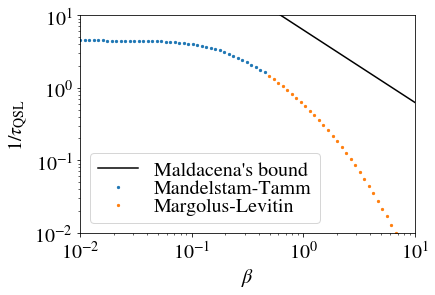

In [22]:
plt.figure()
plt.plot(b_arr_num, 2*np.pi/b_arr_num, label="Maldacena's bound", color='black')
#plt.plot(b_arr, 2*deltaE/np.pi, label="MT Analytics GUE")
#plt.plot(b_arr, 2*avE/np.pi, label="ML Analytics GUE")
#plt.scatter(b_arr_num, 2*avE_num/np.pi, label="ML Numerics GUE")
#plt.scatter(b_arr_num, 2*std_beta/np.pi, label="MT Numerics GUE")
#plt.plot(b_arr, 2/np.pi/unifiedAnalyt, label='Analytic QSL')
plt.scatter(b_arr_num[std_beta<NA_E], 2/np.pi/unifiedNum[std_beta<NA_E], label='Mandelstam-Tamm', s=5)
plt.scatter(b_arr_num[std_beta>NA_E], 2/np.pi/unifiedNum[std_beta>NA_E], label='Margolus-Levitin', s=5)
#plt.scatter(b_arr_num, 2/np.pi/unifiedNum, label='Numeric QSL')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 10)
plt.xlim(1e-2, 10)
plt.ylabel(r"$1/\tau_\mathrm{QSL}$")
plt.xlabel(r"$\beta$")
plt.legend(labelspacing=0)
plt.show()